## CS7641 Machine Learning Assignment 3

# Load packages

In [374]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gzip
import numpy as np
import pandas as pd

# classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import FastICA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# Load wine data
### Load both red and white wine datasets.

In [376]:

###############################################################################
###                  Wine quality data sets                          ##########
###############################################################################
### downloaded from here https://archive.ics.uci.edu/ml/datasets/Wine+Quality
### contains different ratings of wine using various measurement from each wine
### the output is 0 to 10 level scores
### 4898 different wine examples


## READ WHITE WINE DATA
data = pd.read_csv('data/winequality-white.csv')
val = data.values   # all values are saved as string in this dataset
numbers = []  # store the final values into numeric numbers

attri_names0 = data.keys()[0]
attri_names = attri_names0.replace('"','')
attributes = attri_names.split(';')[0:-1] # names for all the attributes


# prepare all the data
for example in val: 
    one_obs = example[0]  # getting one observation, it was saved as string, and all attributes are together
    all_string = one_obs.split(';')
    all_val = [float(item) for item in all_string]
    numbers.append(all_val)

numbers = np.asarray(numbers)

# perpare the data and labels
wine_data_white  = numbers[:, 0:-1]
wine_labels_white = np.asarray(numbers[:, -1], dtype=int)

print('Total number of white wine example selected:')
print(len(wine_data_white))



## READ RED WINE DATA
data = pd.read_csv('data/winequality-red.csv')
val = data.values   # all values are saved as string in this dataset
numbers = []  # store the final values into numeric numbers

attri_names0 = data.keys()[0]
attri_names = attri_names0.replace('"','')
attributes = attri_names.split(';')[0:-1] # names for all the attributes


# prepare all the data
for example in val: 
    one_obs = example[0]  # getting one observation, it was saved as string, and all attributes are together
    all_string = one_obs.split(';')
    all_val = [float(item) for item in all_string]
    numbers.append(all_val)

numbers = np.asarray(numbers)

# perpare the data and labels
wine_data_red  = numbers[:, 0:-1]
wine_labels_red = np.asarray(numbers[:, -1], dtype=int)

print('Total number of red wine example selected:')
print(len(wine_data_red))

# use red and white wine data combined.
wine_type='all'  # 'white', 'red', 'all'

if wine_type=='white':  wine_data = wine_data_white; wine_labels = wine_labels_white
elif wine_type=='red':  wine_data = wine_data_red;   wine_labels = wine_labels_red
elif wine_type=='all':  
    wine_data = np.concatenate((wine_data_white, wine_data_red), axis=0)
    wine_labels = np.concatenate((wine_labels_white, wine_labels_red), axis=0)
    
print('Total number of wine example selected:')
print(len(wine_data))  


Total number of white wine example selected:
4898
Total number of red wine example selected:
1599
Total number of wine example selected:
6497


### Reform the wine data from numerical scale into 'bad', 'ok', 'good' wine.
This will help to reduce the severity of data imbalance in wine dataset. 

[6 6 6 ... 6 5 6]


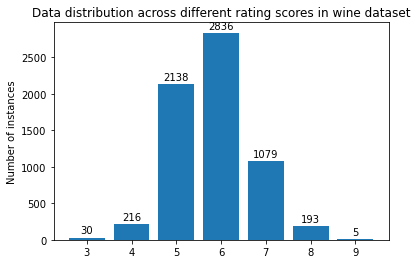

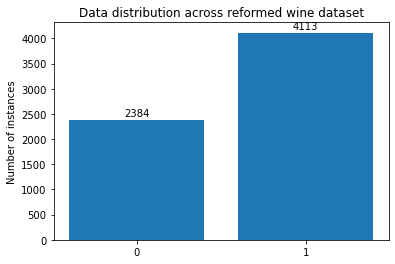

In [381]:
###############################################################
######## Original wine dataset with rating from 3 to 9 ########
###############################################################
print(wine_labels)
# investigate the number of classes in each case.
num_instances = []  # store the number of instances for each class
total_class = list(set(wine_labels)) # figure out how many classes are there in the training data
y_train_wine_array = np.asarray(wine_labels)
for a_class in total_class:
    num_instances.append( len(np.where(y_train_wine_array == a_class)[0]) )
    

# plot a figure to show the number of instances in each class in the training data
#plt.figure()
fig, ax = plt.subplots()
p1 = ax.bar(total_class, num_instances)
plt.ylabel('Number of instances')
plt.title('Data distribution across different rating scores in wine dataset')
ax.bar_label(p1, padding=2)
ax.set_xticks(total_class)


###############################################################
######## Reform wine dateset to be bad, OK, good wine #########
###############################################################

wine_labels_reform = np.zeros_like(wine_labels)
wine_labels_reform[wine_labels<=5] = 0  # bad wine
#wine_labels_reform[wine_labels==6] = 1  # OK wine
wine_labels_reform[wine_labels>=6] = 1  # good wine


# investigate the number of classes in each case.
num_instances_reform = []  # store the number of instances for each class
total_class_reform = list(set(wine_labels_reform)) # figure out how many classes are there in the training data
y_train_wine_array = np.asarray(wine_labels_reform)
for a_class in total_class_reform:
    num_instances_reform.append( len(np.where(y_train_wine_array == a_class)[0]) )
    
fig, ax = plt.subplots()
p1 = ax.bar(total_class_reform, num_instances_reform)
plt.ylabel('Number of instances')
plt.title('Data distribution across reformed wine dataset')
ax.bar_label(p1, padding=2)
ax.set_xticks(total_class_reform)



# standardized my data
scalar      = StandardScaler()
scaled_data = scalar.fit_transform(wine_data)
mydata = scaled_data 
mylabels = wine_labels_reform;


    

# Define helper functions
Will be used later for plotting

In [383]:
# some helper functions will be used later to plot the figures.

# A useful post to read about Silhouette Coefficient Analysis can be found here: 
# https://towardsdatascience.com/k-means-clustering-how-it-works-finding-the-optimum-number-of-clusters-in-the-data-13d18739255c

def silhouette_avg_plot(mydata, max_cluster, model_type = 'EM'):
    
    '''
    Generate figures for average silhouette score.
    model_type, 'EM' or 'kmeans'
    '''
    silhouette_scores = [] # collect the average silhouette score for each given hyperparameter of cluster
    distortions = []       # used to plot the distortion curve and find the elbow
    
    if model_type == 'EM':
        for cluser in range(2,max_cluster):
            EM_model = GaussianMixture(n_components=cluser,random_state=0)
            EM_model.fit(mydata)
            cluster_labels = EM_model.predict(mydata)
            
            # Compute the average scores for each cluster
            silhouette_avg = silhouette_score(mydata, cluster_labels)
            silhouette_scores.append(silhouette_avg)  # track the average silhouette_scores

        plt.figure()
        plt.plot(np.arange(2,max_cluster), silhouette_scores, '--.')
        plt.ylabel('silhouette_avg score')
        plt.xlabel('Number of clusters')
        plt.title('Silhouette avgerage score over iterations')
          
    elif model_type == 'kmeans':  
        #for cluser in range(2,max_cluster):   
        silhouette_scores = [] # collect the average silhouette score for each given hyperparameter of cluster
        distortions = []       # used to plot the distortion curve and find the elbow

        for cluser in range(2,max_cluster):

            kmeans_model = KMeans(n_clusters=cluser, random_state=0)
            kmeans_model.fit(mydata)
            cluster_labels = kmeans_model.labels_

            # Compute the average scores for each cluster
            silhouette_avg = silhouette_score(mydata, cluster_labels)
            silhouette_scores.append(silhouette_avg)  # track the average silhouette_scores

            distortions.append(kmeans_model.inertia_) # track the distortion

        plt.figure()
        plt.plot(np.arange(2,max_cluster), silhouette_scores, '--.')
        plt.ylabel('silhouette_avg score')
        plt.xlabel('Number of clusters')
        plt.title('Silhouette avgerage score over iterations')

        plt.figure()
        plt.plot(np.arange(2,max_cluster), distortions, '--.')
        plt.ylabel('Distortion')
        plt.xlabel('Number of clusters')
        plt.title('Distortion over iterations')

        
        
        
def silhouette_and_data_plot(cluser, mydata,  attributes=None, max_cluster=10,
                             model_type='kmeans', data_type='normal',
                             xlim=[2, 14],ylim=[0.0, 1.4], zlim=[0.0, 200]):
    
    '''
    Generate figures for silhouette scores for all samples.
    
    Inputs:
    model_type,
        what type of clustering model to use, 'kmeans' or 'EM'
    data_type,
        what type of data used,
        'normal':  normal dataset without dimensionality reduction.
        'reduced':  dataset with dimensionality reduction.
    '''
    
    X = mydata
    
    if model_type=='kmeans':
        kmeans_model = KMeans(n_clusters=cluser, random_state=0)
        kmeans_model.fit(X)
        cluster_labels = kmeans_model.labels_
        
    elif model_type=='EM':
        EM_model = GaussianMixture(n_components=cluser,random_state=0)
        EM_model.fit(mydata)
        cluster_labels = EM_model.predict(mydata)    

    # Compute the average scores for each cluster
    silhouette_avg = silhouette_score(X, cluster_labels)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    ###### Reorganize the silhouette score for each cluster and sort them
    ###### Will use later to plot the figure for silhouette score for each sample
    # this section of code is modified from this post
    # https://towardsdatascience.com/k-means-clustering-how-it-works-finding-the-optimum-number-of-clusters-in-the-data-13d18739255c

    #################################################
    # Create a subplot with 1 row and 2 columns

    fig = plt.figure()
    ax1 = fig.add_subplot()

    #fig.set_size_inches(18, 7)
    ##############################################################################
    #########   first subplot, silhouette scores for all samples    ##############
    ##############################################################################
    y_lower = 10
    for i in range(cluser):
        # for each cluster, aggregate the silhouette scores for samples and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / max_cluster)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")   
    ax1.set_yticks([])  # Clear the yaxis labels / ticks


    ##############################################################################
    #########   second subplot, clusters with first two or three features    ##############
    ##############################################################################

    fig = plt.figure()
    ax2 = fig.add_subplot(projection='3d')
    
    if data_type =='normal':
        a_idx=0; b_idx=1; c_idx=6;
    elif data_type =='reduced':
        a_idx=0; b_idx=1; c_idx=2;

    colors = cm.nipy_spectral(cluster_labels.astype(float) / cluser)
    ax2.scatter(X[:, a_idx], X[:, b_idx], X[:, c_idx],  marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    ## Labeling the clusters
    #centers = kmeans_model.cluster_centers_
    ## Draw white circles at cluster centers
    #ax2.scatter(centers[:, a_idx], centers[:, b_idx], centers[:, c_idx], marker='o',
    #            c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
    #    ax2.scatter(c[a_idx], c[b_idx], c[c_idx], marker='$%d$' % i, alpha=1,
    #                s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data." "with n_clusters = %d" % cluser)
    if data_type =='normal':
        ax2.set_xlabel(attributes[a_idx])
        ax2.set_ylabel(attributes[b_idx])
        ax2.set_zlabel(attributes[c_idx])

    if data_type =='reduced':
        ax2.set_xlabel('1st component')
        ax2.set_ylabel('2nd component')
        ax2.set_zlabel('3rd component')
        
    if len(xlim)==2: ax2.set_xlim(xlim)
    if len(ylim)==2: ax2.set_ylim(ylim)
    if len(zlim)==2: ax2.set_zlim(zlim)
      
        
def bic_plot(mydata, max_cluster):        
    '''
    At this moment, BIC plot is only work for EM clustering model here
    
    Code in this section was adapted from this post.
    https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    '''

    # Bayesin Information Criterion score when using clustering from 2 to 10
    X = mydata
    ncluster = np.arange(2, max_cluster+1)
    bics=[]; bics_err=[];

    for acluster in ncluster:
        tmp_bic=[]
        # also select some random state to recompute the model when given a number of clusters    
        for randomstate in range(1,100, 5):
            EM_model=GaussianMixture(acluster, random_state=randomstate).fit(X)
            tmp_bic.append(EM_model.bic(X))
        val=np.mean(tmp_bic); err=np.std(tmp_bic);
        bics.append(val); bics_err.append(err);   # store the computation results for later plotting use.


    # plot the BIC score as the number of clusters
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.errorbar(ncluster, bics, yerr=bics_err, label='BIC')
    ax1.set_title("BIC Scores")
    ax1.set_xticks(ncluster)
    ax1.set_xlabel("Number of Clusters")
    ax1.set_ylabel("BIC")

    # plot the gradient of the BIC score
    fig = plt.figure()
    ax2 = fig.add_subplot()
    ax2.errorbar(ncluster, np.gradient(bics), yerr=bics_err, label='BIC')
    ax2.set_title("Gradient of BIC Scores")
    ax2.set_xticks(ncluster)
    ax2.set_xlabel("Number of Clusters")
    ax2.set_ylabel("grad(BIC)")

        
        

# Using raw data to run clustering

K-means clustering and Expectation Maximization clustering on the datasets.


## k-means clustering

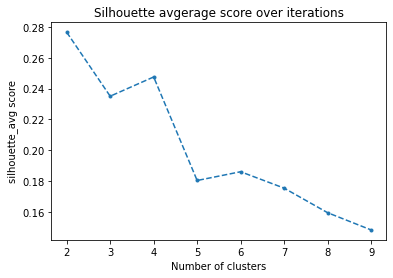

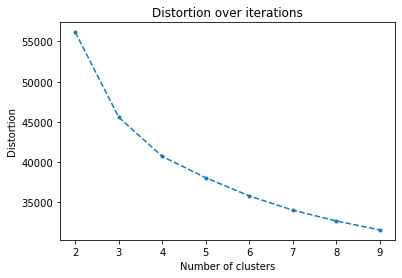

In [384]:
# Average silhouette score when using clustering from 2 to 10
max_cluster = 10;
model_type = 'kmeans'
silhouette_avg_plot(mydata, max_cluster, model_type = model_type)

#### Visualize the silhouette score and data after clustering

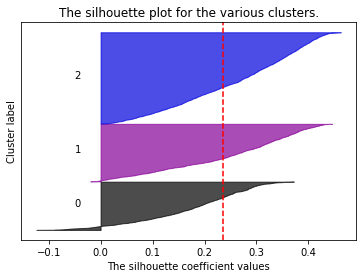

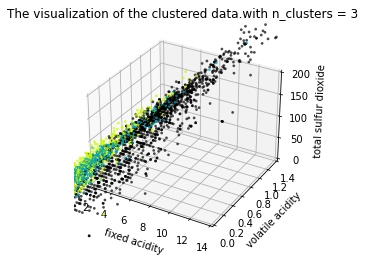

In [387]:
cluser = 3; max_cluster=10;
silhouette_and_data_plot(cluser, mydata, model_type='kmeans', attributes=attributes, max_cluster=max_cluster,
                         xlim=[2, 14], ylim=[0.0, 1.4], zlim=[0.0, 200])

## Expectation maximization

#### Average silhouette score

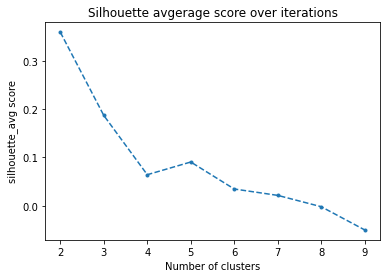

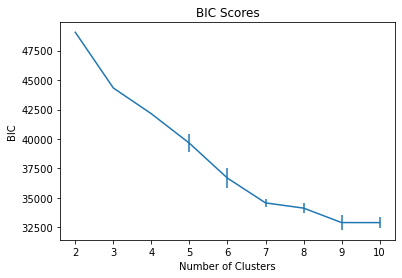

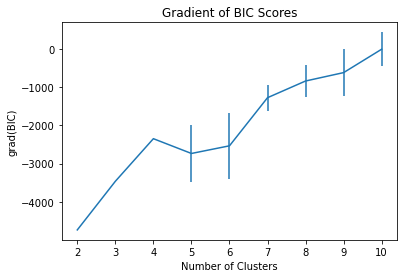

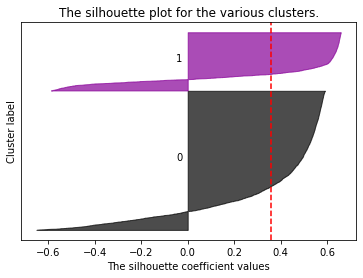

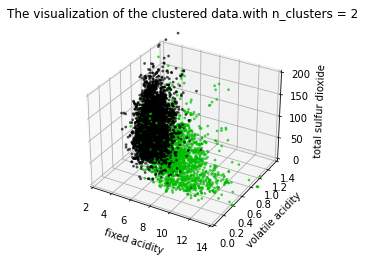

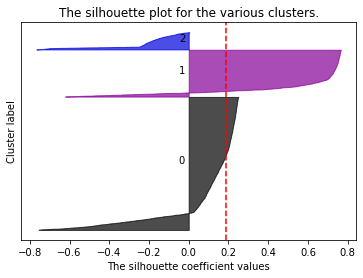

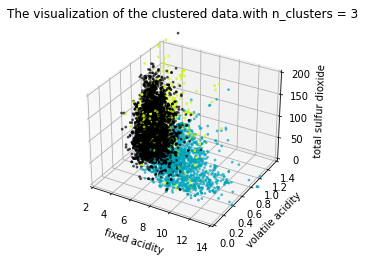

In [107]:
# Average silhouette score when using clustering from 2 to 10
max_cluster = 10;
model_type  = 'EM'
silhouette_avg_plot(mydata, max_cluster, model_type = model_type)

# Bayesin Information Criterion score when using clustering from 2 to 10
bic_plot(mydata, max_cluster)

# plot the silhouette score over different clusters and visualize the data.
for cluser in range(2,3+1):
    silhouette_and_data_plot(cluser, mydata, model_type='EM', xlim=[2, 14], ylim=[0.0, 1.4], zlim=[0.0, 200])

### Running neural network with original data, no dimensionality reduction.

In [145]:
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'tanh',
                        alpha              = 0.001,  # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001,  # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the raw data without dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(mydata, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.764864344814316
Testing accuracy is: 0.7592307692307693


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Dimensionality reduction


## PCA


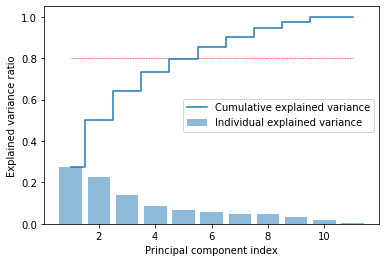

In [149]:
# standardize the data.
scalar = StandardScaler()
scaled = scalar.fit_transform(mydata)

# First, conduct PCA to do keep all the components just to see how they can represent the 
# dataset with variance in the dataset.
pca = PCA(n_components=None)
data_pca = pca.fit_transform(scaled)

# plot figures that the PCA explain the data in accounting the variance each 
# component can represent
plt.figure()
plt.bar(range(1,len(attributes)+1), pca.explained_variance_ratio_, alpha=0.5,
        align='center', label='Individual explained variance')

cum_var = np.cumsum(pca.explained_variance_ratio_ )
plt.step(range(1,len(attributes)+1), cum_var, where='mid',
         label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.hlines(0.8, 1, len(attributes), linestyle='--', linewidth=0.5, color='r')

In [150]:
# now since we know that when PCA components is 5, from component 1 to 5, it can explain 80% of the variance cumulatively
# in the dataset. Thus, we keep 5 components.
pca = PCA(n_components=5)
data_reduced_PCA = pca.fit_transform(scaled)
print('Raw data with size:')
print(mydata.shape)
print('After dimensionality reduction with PCA:')
print(data_reduced_PCA.shape)

Raw data with size:
(6497, 11)
After dimensionality reduction with PCA:
(6497, 5)


### k-means clustering on data with reduced dimensionality using PCA

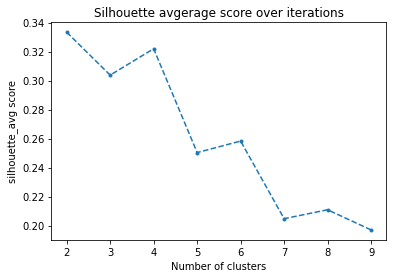

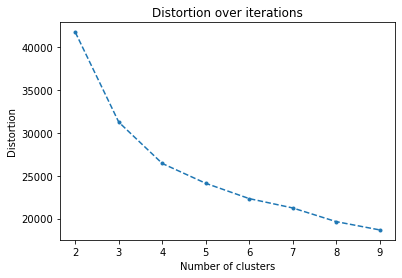

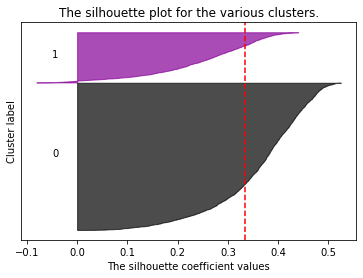

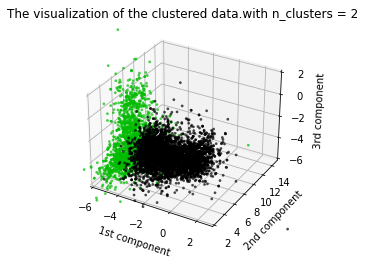

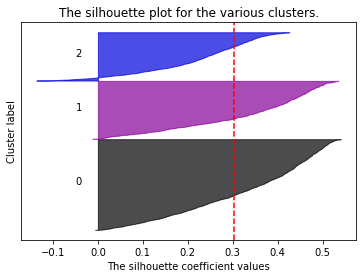

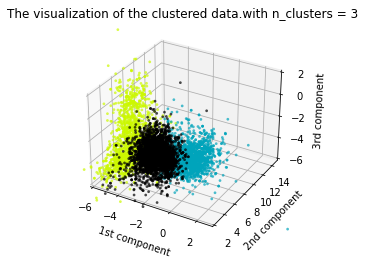

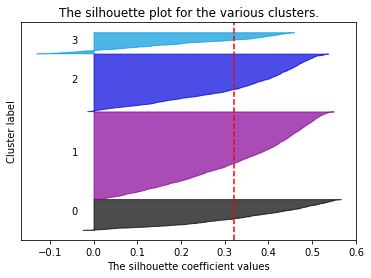

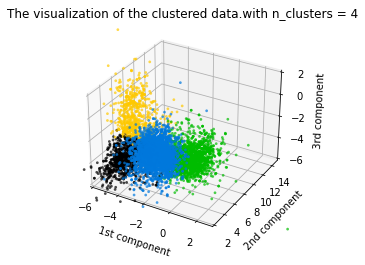

In [388]:
# Average silhouette score when using clustering from 2 to 10
max_cluster = 10;
model_type = 'kmeans'
silhouette_avg_plot(data_reduced_PCA, max_cluster, model_type = model_type)

# plot clustering with 3 and 4 to see how the cluster look like
for cluser in range (2, 5):
    silhouette_and_data_plot(cluser, data_reduced_PCA, model_type='kmeans', data_type='reduced',
                             xlim=[-6, 3], ylim=[2, 15], zlim=[-6, 2])


In [196]:
################ Adding clustering labels and distance to its centroid as new features 
################ into the dimensionality reduced data

# based on above sihoutte score and distortion curve, choose cluster of 4 for k-means
kmeans_model = KMeans(n_clusters=4, random_state=0)
kmeans_model.fit(data_reduced_PCA)
cluster_labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_

# calculate the Eclidean distance between each point to its corresponding center.
dist_list = []
for n in range(len(data_reduced_PCA)):
    a_point = data_reduced_PCA[n]          # get a point in the dataset
    a_cluster_label = cluster_labels[0]    # get the label of this point in the clusters
    my_center = centers[a_cluster_label]
    dist = np.sqrt(sum(a_point-my_center)**2)  # the distance between a given data point to its corresponding center
    dist_list.append(dist)

dist_list = np.asarray(dist_list)  # get all the distances
# concatenate the clustering label and the distance after the reduced dimension data, serving as additional features
data_reduced_PCA_features_Kmeans = np.concatenate(
    (data_reduced_PCA, cluster_labels[:, np.newaxis], dist_list[:, np.newaxis]),axis=1)


### EM clustering on data with reduced dimensionality using PCA

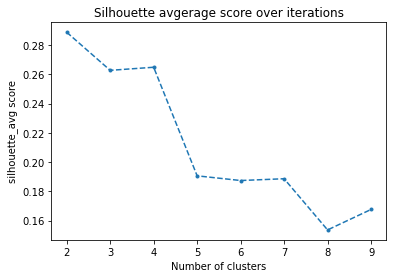

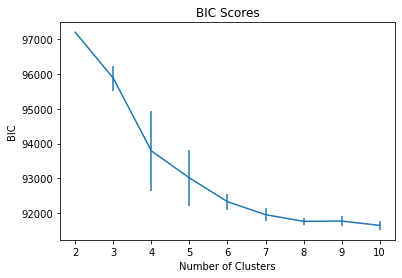

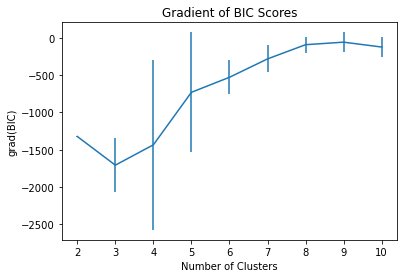

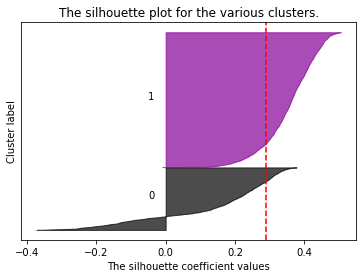

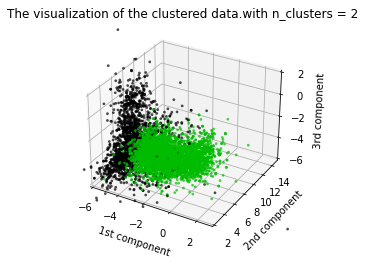

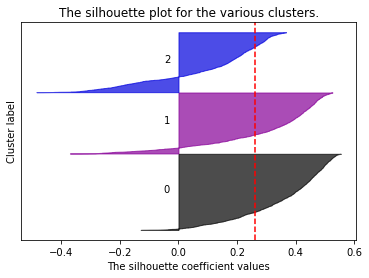

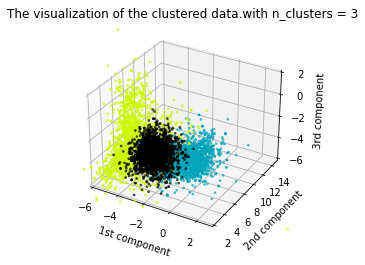

In [108]:
# Average silhouette score when using clustering from 2 to 10
max_cluster = 10;
model_type = 'EM'
silhouette_avg_plot(data_reduced_PCA, max_cluster, model_type = model_type)

# Bayesin Information Criterion score when using clustering from 2 to 10
bic_plot(data_reduced_PCA, max_cluster)

# plot the silhouette score over different clusters and visualize the data.
for cluser in range (2, 4):
    silhouette_and_data_plot(cluser, data_reduced_PCA, model_type='EM', data_type='reduced',
                             xlim=[-6, 3], ylim=[2, 15], zlim=[-6, 2])

In [200]:
################ Adding clustering labels and distance to its centroid as new features 
################ into the dimensionality reduced data

# based on above sihoutte score and bic curve, choose cluster of 4 for EM clustering
EM_model = GaussianMixture(n_components=4,random_state=0)
EM_model.fit(data_reduced_PCA)
cluster_labels = EM_model.predict(data_reduced_PCA)   

centers = EM_model.means_

# calculate the Eclidean distance between each point to its corresponding center.
dist_list = []
for n in range(len(data_reduced_PCA)):
    a_point = data_reduced_PCA[n]          # get a point in the dataset
    a_cluster_label = cluster_labels[0]    # get the label of this point in the clusters
    my_center = centers[a_cluster_label]
    dist = np.sqrt(sum(a_point-my_center)**2)  # the distance between a given data point to its corresponding center
    dist_list.append(dist)

dist_list = np.asarray(dist_list)  # get all the distances
# concatenate the clustering label and the distance after the reduced dimension data, serving as additional features
data_reduced_PCA_features_EM = np.concatenate(
    (data_reduced_PCA, cluster_labels[:, np.newaxis], dist_list[:, np.newaxis]),axis=1)

In [201]:
print(data_reduced_PCA_features_EM.shape)

(6497, 7)


### Running neural network algrithm for classification on the dimension reduced data using PCA

In [151]:
## PCA reduced dimensionality data
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'tanh',
                        alpha              = 0.001,    # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001, # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_PCA, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.7827592842024245
Testing accuracy is: 0.7546153846153846


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [202]:
## PCA reduced dimensionality data + Kmean clustering labels and distance
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'tanh',
                        alpha              = 0.001,    # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001, # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_PCA_features_Kmeans, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.7896863575139503
Testing accuracy is: 0.7576923076923077


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [203]:
## PCA reduced dimensionality data + EM clustering labels and distance
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'tanh',
                        alpha              = 0.001,    # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001, # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_PCA_features_EM, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.8008466422936309
Testing accuracy is: 0.7569230769230769


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# ICA

Working n_component= 2
Working n_component= 3
Working n_component= 4
Working n_component= 5
Working n_component= 6
Working n_component= 7
Working n_component= 8
Working n_component= 9
Working n_component= 10


Text(0, 0.5, 'Accuracy')

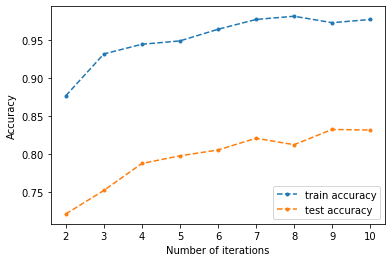

In [418]:
####################################################################################
## USING BOOSTING ALGORITHM TO TEST WHICH n_components HAS WHAT DECODING ACCURACY ##

test_acc_list = []
train_acc_list = []
components_range = range(2, 11)
for n_components in components_range:
    print('Working n_component=', n_components)
    FICA_data=FastICA(n_components=n_components)
    
    # conduct dimensionality reduction using ICA
    data_reduced_ICA = FICA_data.fit_transform(mydata)
    
    # after getting dimensionality reduced data, traing this data into training the testing data    
    X_train, X_test, y_train, y_test = train_test_split(data_reduced_ICA, mylabels, test_size=0.2, random_state=42)

    # initialize the bosting mode using the best hyperparameters from assignment1
    model = GradientBoostingClassifier(n_estimators=60,learning_rate=0.1,max_depth=8)

    model     = model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    pred_all  = model.predict(X_test)
    test_acc  = metrics.accuracy_score(y_test, pred_all)
    test_acc_list.append(test_acc)
    train_acc_list.append(train_acc)

plt.figure()
plt.plot(components_range, train_acc_list, '--.')
plt.plot(components_range, test_acc_list, '--.')
plt.legend(['train accuracy','test accuracy'])
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')

#### Kurtosis

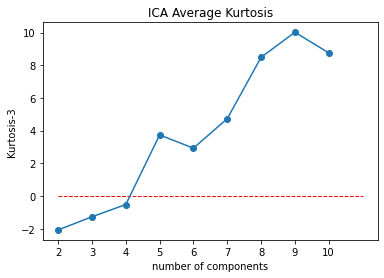

In [415]:
# Kurtosis
# https://programtalk.com/python-examples/scipy.stats.kurtosis/
import scipy
kurt = []
start = 2
end = 11
ncomponent = np.arange(start, end)
for i in ncomponent:
    ica = FastICA(n_components=i, max_iter=10000, tol=0.1,random_state=12)
    data_reduced_ICA = ica.fit_transform(mydata)
    
    kurtosis = scipy.stats.kurtosis(data_reduced_ICA)
    kurt_i_component = np.mean(kurtosis)-3     
    kurt.append(kurt_i_component)


plt.plot(ncomponent, kurt, '-o')
plt.xlabel('number of components')
plt.xticks(ncomponent)
plt.ylabel('Kurtosis-3')
plt.hlines(0, start, end, linewidth=1, linestyle='--', color='r')
plt.title("ICA Average Kurtosis")
plt.show()

In [425]:
# Based on above results, we use n_components=9
# conduct dimensionality reduction using ICA
FICA_data=FastICA(n_components=9)
data_reduced_ICA = FICA_data.fit_transform(mydata)

print('Raw data shape:')
print(mydata.shape)
print('Reduced data shape:')
print(data_reduced_ICA.shape)

Raw data shape:
(6497, 11)
Reduced data shape:
(6497, 9)


### k-means clustering on data with reduced dimensionality using ICA

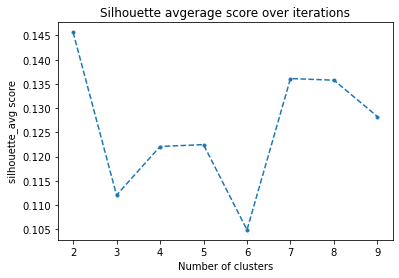

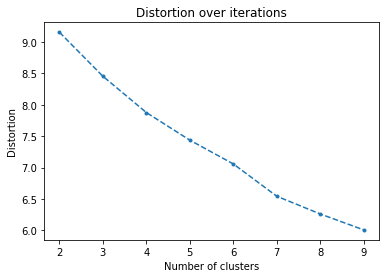

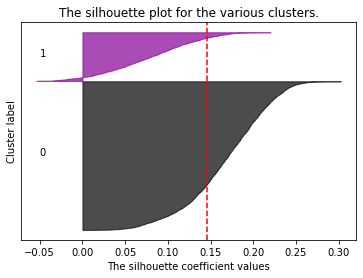

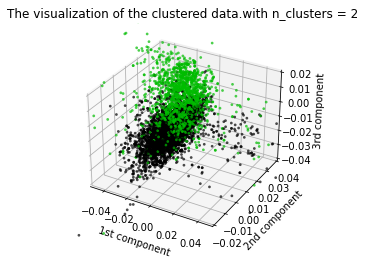

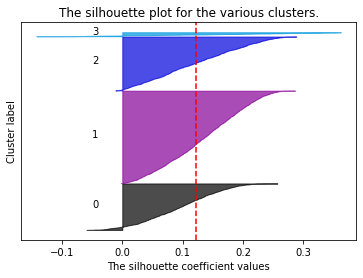

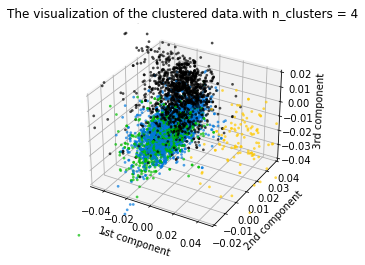

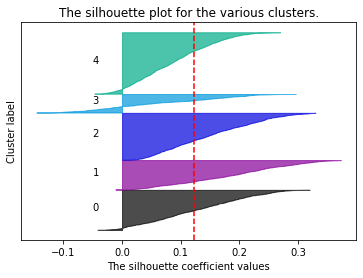

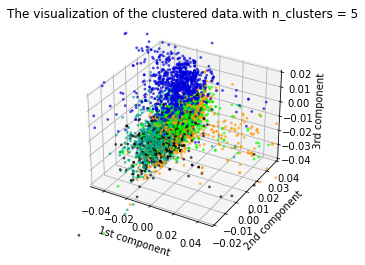

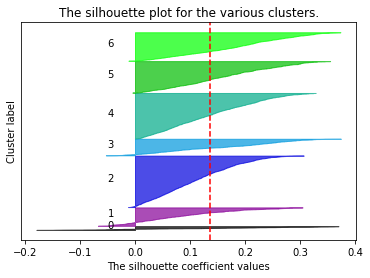

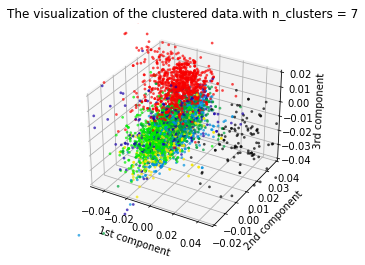

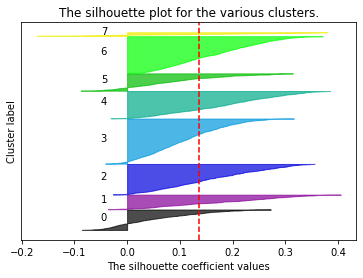

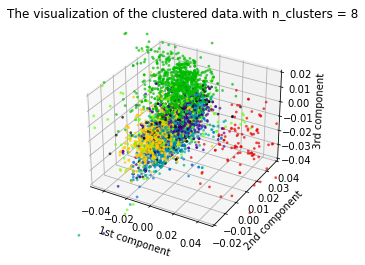

In [420]:
# Average silhouette score when using clustering from 2 to 10
max_cluster = 10;
model_type = 'kmeans'
silhouette_avg_plot(data_reduced_ICA, max_cluster, model_type = model_type)

# plot clustering with 3 and 4 to see how the cluster look like
for cluser in [2,4,5,7,8]:
    silhouette_and_data_plot(cluser, data_reduced_ICA, model_type='kmeans', data_type='reduced',
                             xlim=[-0.05, 0.05], ylim=[-0.02,0.04], zlim=[-0.04, 0.02])


In [421]:
# based on the above scores, we choose number of 6 classes in k-means clustering

################ Adding clustering labels and distance to its centroid as new features 
################ into the dimensionality reduced data

# based on above sihoutte score and distortion curve, choose cluster of 46 for k-means
kmeans_model   = KMeans(n_clusters=2, random_state=0)
kmeans_model.fit(data_reduced_ICA)
cluster_labels = kmeans_model.labels_
centers        = kmeans_model.cluster_centers_

# calculate the Eclidean distance between each point to its corresponding center.
dist_list = []
for n in range(len(data_reduced_ICA)):
    a_point         = data_reduced_ICA[n]          # get a point in the dataset
    a_cluster_label = cluster_labels[0]    # get the label of this point in the clusters
    my_center       = centers[a_cluster_label]
    dist            = np.sqrt(sum(a_point-my_center)**2)  # the distance between a given data point to its corresponding center
    dist_list.append(dist)

dist_list = np.asarray(dist_list)  # get all the distances
# concatenate the clustering label and the distance after the reduced dimension data, serving as additional features
data_reduced_ICA_features_Kmeans = np.concatenate(
    (data_reduced_ICA, cluster_labels[:, np.newaxis], dist_list[:, np.newaxis]),axis=1)

print(data_reduced_ICA_features_Kmeans.shape)

(6497, 12)


### EM clustering on data with reduced dimensionality ICA

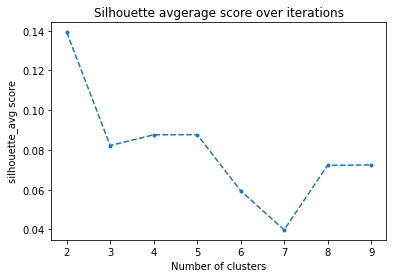

In [423]:
# Average silhouette score when using clustering from 2 to 10
max_cluster = 10;
model_type = 'EM'
silhouette_avg_plot(data_reduced_ICA, max_cluster, model_type = model_type)

# Bayesin Information Criterion score when using clustering from 2 to 10
#bic_plot(data_reduced_ICA, max_cluster)



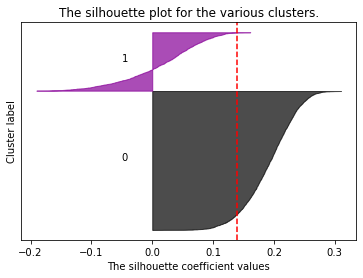

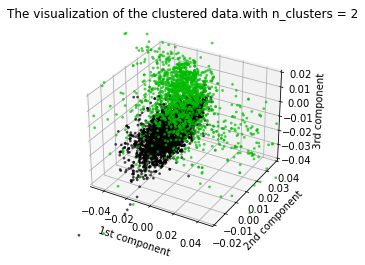

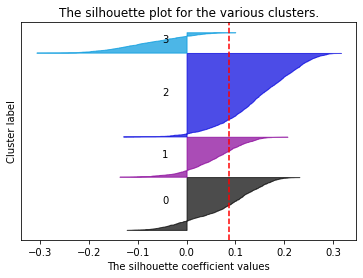

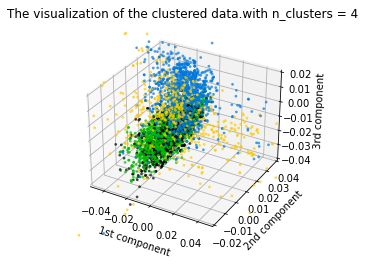

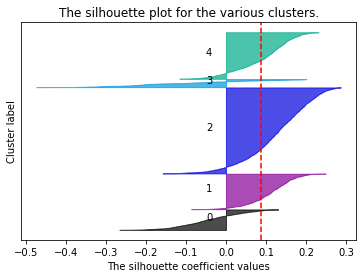

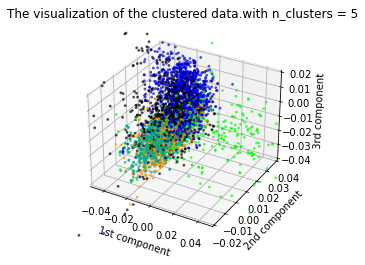

In [424]:
# plot the silhouette score over different clusters and visualize the data.
for cluser in [2,4,5]:
    silhouette_and_data_plot(cluser, data_reduced_ICA, model_type='EM', data_type='reduced',
                             xlim=[-0.05, 0.05], ylim=[-0.02,0.04], zlim=[-0.04, 0.02])

In [224]:
################ Adding clustering labels and distance to its centroid as new features 
################ into the dimensionality reduced data

# based on above sihoutte score and bic curve, choose cluster of 3 for EM clustering
EM_model = GaussianMixture(n_components=3,random_state=0)
EM_model.fit(data_reduced_ICA)
cluster_labels = EM_model.predict(data_reduced_ICA)   

centers = EM_model.means_

# calculate the Eclidean distance between each point to its corresponding center.
dist_list = []
for n in range(len(data_reduced_ICA)):
    a_point         = data_reduced_ICA[n]    # get a point in the dataset
    a_cluster_label = cluster_labels[0]      # get the label of this point in the clusters
    my_center       = centers[a_cluster_label]
    dist            = np.sqrt(sum(a_point-my_center)**2)  # the distance between a given data point to its corresponding center
    dist_list.append(dist)

dist_list = np.asarray(dist_list)  # get all the distances
# concatenate the clustering label and the distance after the reduced dimension data, serving as additional features
data_reduced_ICA_features_EM = np.concatenate(
    (data_reduced_ICA, cluster_labels[:, np.newaxis], dist_list[:, np.newaxis]),axis=1)

print(data_reduced_ICA_features_EM.shape)

(6497, 11)


### Running neural network algrithm for classification on the dimension reduced data using ICA

In [225]:
# with ICA reduced dimentionality data
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'tanh',
                        alpha              = 0.001,  # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001,  # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_ICA, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.7361939580527227
Testing accuracy is: 0.7392307692307692


In [226]:
# with ICA reduced dimentionality data + kmeans feature
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'tanh',
                        alpha              = 0.001,  # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001,  # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_ICA_features_Kmeans, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.7427361939580527
Testing accuracy is: 0.7438461538461538


In [227]:
# with ICA reduced dimentionality data + EM feature
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'tanh',
                        alpha              = 0.001,  # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001,  # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_ICA_features_EM, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.7394650760053877
Testing accuracy is: 0.7438461538461538


# Randomized Projections

In [433]:
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection, johnson_lindenstrauss_min_dim


min_dim = johnson_lindenstrauss_min_dim(n_samples=mydata.shape[0], eps=0.01)
print(mydata.shape[1])
print(mydata.shape[0])
print(min_dim)
# a good post to refer to is
# https://stackabuse.com/random-projection-theory-and-implementation-in-python-with-scikit-learn/

11
6497
707041


Working n_component= 2
Working n_component= 3
Working n_component= 4
Working n_component= 5


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Working n_component= 6


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Working n_component= 7
Working n_component= 8


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Working n_component= 9


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Working n_component= 10


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Working n_component= 11


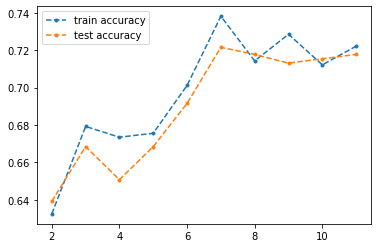

In [228]:
from sklearn import random_projection
#transformer = GaussianRandomProjection(n_components=4, eps=0.01)
#data_reduced_random = transformer.fit_transform(mydata)

#print('Original data shape:')
#print(mydata.shape)
#print('Reduced data shape:')
#print(data_reduced_random.shape)


####################################################################################
## USING BOOSTING ALGORITHM TO TEST WHICH n_components HAS WHAT DECODING ACCURACY ##

test_acc_list = []
train_acc_list = []
components_range = range(2, 12)
for n_components in components_range:
    print('Working n_component=', n_components)
    transformer = GaussianRandomProjection(n_components=n_components, eps=0.01)
    
    # conduct dimensionality reduction using random projection
    data_reduced_random = transformer.fit_transform(mydata)
    
    # after getting dimensionality reduced data, traing this data into training the testing data    
    X_train, X_test, y_train, y_test = train_test_split(data_reduced_random, mylabels, test_size=0.2, random_state=42)

    # initialize the bosting mode using the best hyperparameters from assignment1
    booster_model_wine = GradientBoostingClassifier(n_estimators=60,learning_rate=0.1,max_depth=8)

    model     = model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    pred_all  = model.predict(X_test)
    test_acc  = metrics.accuracy_score(y_test, pred_all)
    test_acc_list.append(test_acc)
    train_acc_list.append(train_acc)

plt.figure()
plt.plot(components_range, train_acc_list, '--.')
plt.plot(components_range, test_acc_list, '--.')
plt.legend(['train accuracy','test accuracy'])

Component i: 2
Component i: 3
Component i: 4
Component i: 5
Component i: 6
Component i: 7
Component i: 8
Component i: 9
Component i: 10
Component i: 11


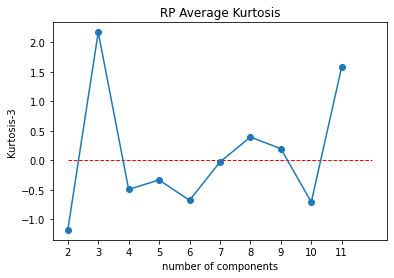

In [430]:
# Kurtosis

kurt = []
kurt = []
start = 2
end = 12
ncomponent = np.arange(start, end)
for i in ncomponent:
    print('Component i:', i)
    #ica = FastICA(n_components=i, max_iter=10000, tol=0.1,random_state=12)
    #data_reduced_ICA = ica.fit_transform(mydata)
    
    transformer = GaussianRandomProjection(n_components=n_components, eps=0.01)
    # conduct dimensionality reduction using random projection
    data_reduced_random = transformer.fit_transform(mydata)
    
    
    kurt_i_component = pd.DataFrame(data_reduced_random)
    kurt_i_component = kurt_i_component.kurt(axis=0)
    kurt_i_component = kurt_i_component.abs().mean()-3
    kurt.append(kurt_i_component)


plt.plot(ncomponent, kurt, '-o')
plt.xlabel('number of components')
plt.xticks(ncomponent)
plt.ylabel('Kurtosis-3')
plt.title("RP Average Kurtosis")
plt.hlines(0, start, end, linewidth=1, linestyle='--', color='r')
plt.show()

In [441]:
# Based on above results, select n_components=7
transformer = GaussianRandomProjection(n_components=7, eps=0.01)
# conduct dimensionality reduction using random projection
data_reduced_random = transformer.fit_transform(mydata)
print(data_reduced_random.shape)

(6497, 7)


### k-means clustering on data with reduced dimensionality using Random Projection

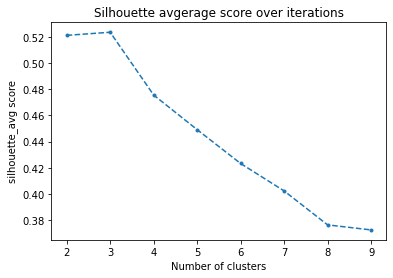

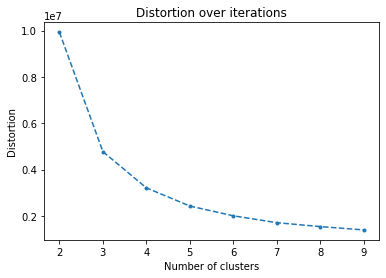

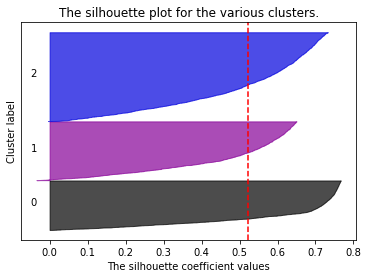

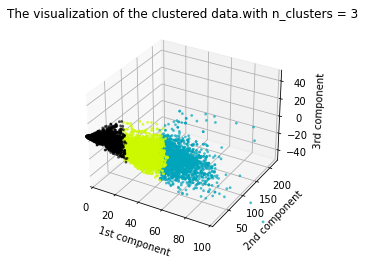

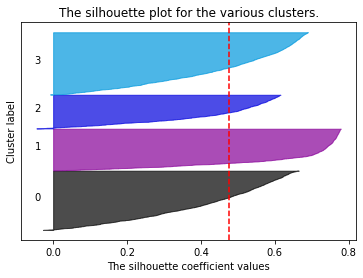

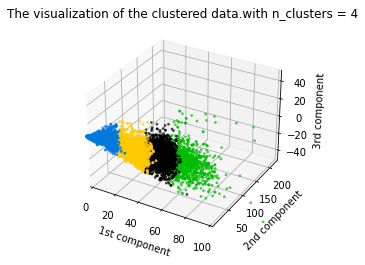

In [231]:
# Average silhouette score when using clustering from 2 to 10
max_cluster = 10;
model_type = 'kmeans'
silhouette_avg_plot(data_reduced_random, max_cluster, model_type = model_type)

# plot clustering with 3 and 4 to see how the cluster look like
for cluser in range (3, 5):
    silhouette_and_data_plot(cluser, data_reduced_random, model_type='kmeans', data_type='reduced',
                             xlim=[0, 100], ylim=[], zlim=[-50, 50])

In [444]:
# based on the above scores, we choose number of 3 classes in k-means clustering

################ Adding clustering labels and distance to its centroid as new features 
################ into the dimensionality reduced data

# based on above sihoutte score and distortion curve, choose cluster of 3 for k-means
kmeans_model   = KMeans(n_clusters=3, random_state=0)
kmeans_model.fit(data_reduced_random)
cluster_labels = kmeans_model.labels_
centers        = kmeans_model.cluster_centers_

# calculate the Eclidean distance between each point to its corresponding center.
dist_list = []
for n in range(len(data_reduced_random)):
    a_point         = data_reduced_random[n]          # get a point in the dataset
    a_cluster_label = cluster_labels[0]    # get the label of this point in the clusters
    my_center       = centers[a_cluster_label]
    dist            = np.sqrt(sum(a_point-my_center)**2)  # the distance between a given data point to its corresponding center
    dist_list.append(dist)

dist_list = np.asarray(dist_list)  # get all the distances
# concatenate the clustering label and the distance after the reduced dimension data, serving as additional features
data_reduced_random_features_Kmeans = np.concatenate(
    (data_reduced_random, cluster_labels[:, np.newaxis], dist_list[:, np.newaxis]),axis=1)

print(data_reduced_random_features_Kmeans.shape)

(6497, 9)


### EM clustering on data with reduced dimensionality Random Projection

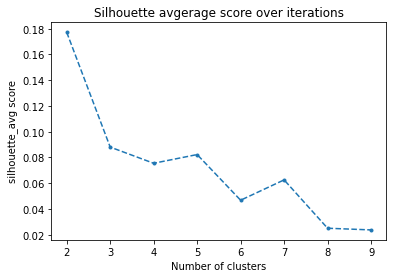

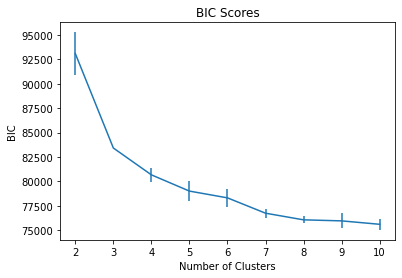

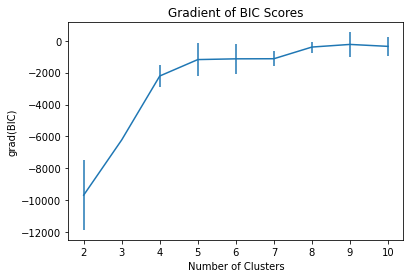

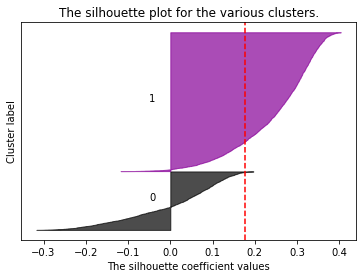

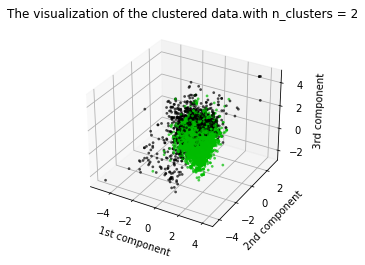

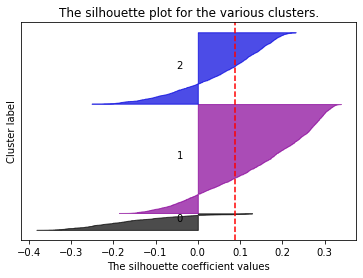

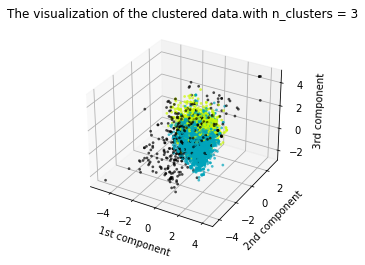

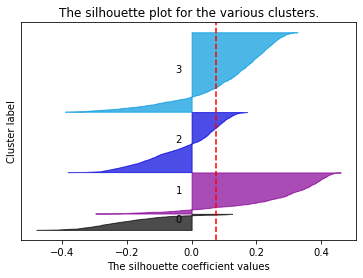

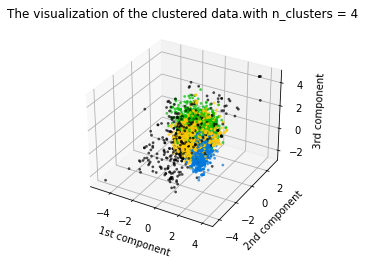

In [431]:
# Average silhouette score when using clustering from 2 to 10
max_cluster = 10;
model_type = 'EM'
silhouette_avg_plot(data_reduced_random, max_cluster, model_type = model_type)

# Bayesin Information Criterion score when using clustering from 2 to 10
bic_plot(data_reduced_random, max_cluster)

# plot the silhouette score over different clusters and visualize the data.
for cluser in range (2, 5):
    silhouette_and_data_plot(cluser, data_reduced_random, model_type='EM', data_type='reduced',
                             xlim=[], ylim=[], zlim=[])

In [445]:
################ Adding clustering labels and distance to its centroid as new features 
################ into the dimensionality reduced data

# based on above sihoutte score and bic curve, choose cluster of 3 for EM clustering
EM_model = GaussianMixture(n_components=5,random_state=0)
EM_model.fit(data_reduced_random)
cluster_labels = EM_model.predict(data_reduced_random)   

centers = EM_model.means_

# calculate the Eclidean distance between each point to its corresponding center.
dist_list = []
for n in range(len(data_reduced_random)):
    a_point         = data_reduced_random[n]    # get a point in the dataset
    a_cluster_label = cluster_labels[0]      # get the label of this point in the clusters
    my_center       = centers[a_cluster_label]
    dist            = np.sqrt(sum(a_point-my_center)**2)  # the distance between a given data point to its corresponding center
    dist_list.append(dist)

dist_list = np.asarray(dist_list)  # get all the distances
# concatenate the clustering label and the distance after the reduced dimension data, serving as additional features
data_reduced_random_features_EM = np.concatenate(
    (data_reduced_random, cluster_labels[:, np.newaxis], dist_list[:, np.newaxis]),axis=1)

print(data_reduced_random.shape)
print(data_reduced_random_features_EM.shape)

(6497, 7)
(6497, 9)


### Running neural network algrithm for classification on the dimension reduced data using Random Projection

In [446]:
# with dimensionality reduced data using random projection
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'tanh',
                        alpha              = 0.001,  # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001,  # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_random, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.7998845487781412
Testing accuracy is: 0.77


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [447]:
# with dimensionality reduced data using random projection + kmeans feature
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'tanh',
                        alpha              = 0.001,  # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001,  # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_random_features_Kmeans, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.8014238984029247
Testing accuracy is: 0.7746153846153846


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [448]:
# with dimensionality reduced data using random projection + EM feature
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'tanh',
                        alpha              = 0.001,  # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001,  # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_random_features_EM, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.7993072926688474
Testing accuracy is: 0.7646153846153846


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Reduce data dimensionality using Random Rorest.
Use random forest algorithm to figure which features are important.
remove the last several non-important features.

In [337]:

model = RandomForestClassifier(n_estimators = 100, random_state = 42, 
                              max_depth=10, n_jobs = -1,
                              oob_score = True,  
                              max_features='sqrt', 
                              min_samples_leaf = 25,
                              verbose = 1,  
                              bootstrap=True, 
                              max_samples  = 0.8) 
model.fit(mydata, mylabels); # Train the model on training data


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


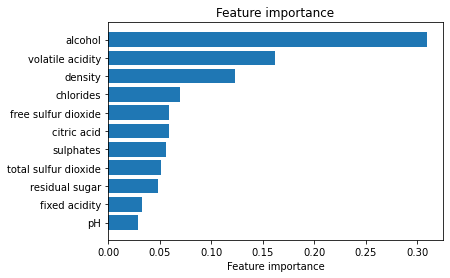

In [359]:
# variable importance
importances = list(model.feature_importances_)

# sort the importance from low to high
importances_sort = np.sort(importances) 
idx = np.argsort(importances) 
attributes_sort = [ attributes[a_idx] for a_idx in idx ]  # sort the attributes according to the order of importances

# plot the feature importance figure
fig, ax = plt.subplots()
y_pos = np.arange(len(importances_sort))
ax.barh(y_pos, importances_sort, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(attributes_sort)
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature importance')
ax.set_title('Feature importance')
plt.show()

In [362]:
# remove the 30% number of least important features
remove_per = 0.3 # remove 30% of its total features
remove_num = int(len(attributes_sort)*remove_per)
column_names = attributes_sort[0:remove_num]  # attributes_sort, the least important features comes first

wine_df     = pd.DataFrame(mydata,columns=attributes)
wine_df.drop(column_names, axis=1, inplace=True)

data_reduced_forest = wine_df.values
print('Original data shape:')
print(mydata.shape)
print('Reduced data shape:')
print(data_reduced_forest.shape)
    


Original data shape:
(6497, 11)
Reduced data shape:
(6497, 8)


### k-means clustering on data with reduced dimensionality using random forest reduction

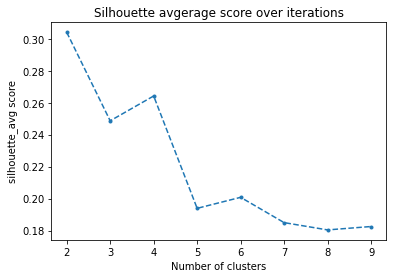

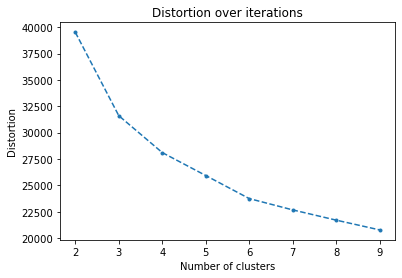

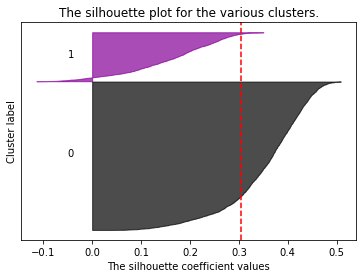

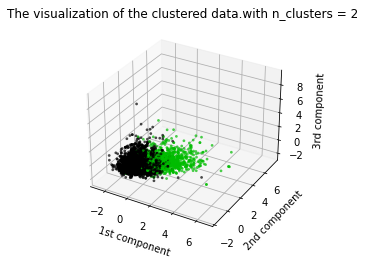

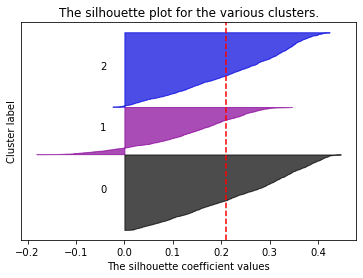

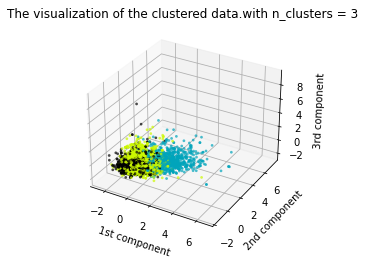

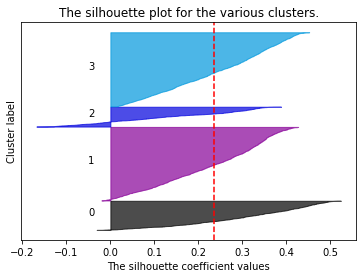

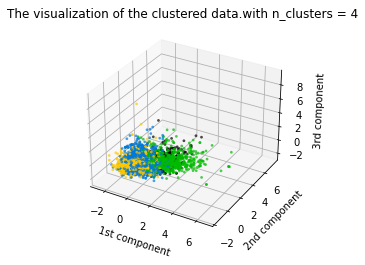

In [365]:
# Average silhouette score when using clustering from 2 to 10
max_cluster = 10;
model_type = 'kmeans'
silhouette_avg_plot(data_reduced_forest, max_cluster, model_type = model_type)

# plot clustering with 3 and 4 to see how the cluster look like
for cluser in range (2, 5):
    silhouette_and_data_plot(cluser, data_reduced_corr, model_type='kmeans', data_type='reduced',
                             xlim=[], ylim=[], zlim=[])

In [366]:
# based on the above scores, we choose number of 3 classes in k-means clustering

################ Adding clustering labels and distance to its centroid as new features 
################ into the dimensionality reduced data

# based on above sihoutte score and distortion curve, choose cluster of 3 for k-means
kmeans_model   = KMeans(n_clusters=2, random_state=0)
kmeans_model.fit(data_reduced_random)
cluster_labels = kmeans_model.labels_
centers        = kmeans_model.cluster_centers_

# calculate the Eclidean distance between each point to its corresponding center.
dist_list = []
for n in range(len(data_reduced_random)):
    a_point         = data_reduced_random[n]          # get a point in the dataset
    a_cluster_label = cluster_labels[0]    # get the label of this point in the clusters
    my_center       = centers[a_cluster_label]
    dist            = np.sqrt(sum(a_point-my_center)**2)  # the distance between a given data point to its corresponding center
    dist_list.append(dist)

dist_list = np.asarray(dist_list)  # get all the distances
# concatenate the clustering label and the distance after the reduced dimension data, serving as additional features
data_reduced_forest_features_Kmeans = np.concatenate(
    (data_reduced_forest, cluster_labels[:, np.newaxis], dist_list[:, np.newaxis]),axis=1)

print(data_reduced_forest_features_Kmeans.shape)

(6497, 10)


### EM clustering on data with reduced dimensionality using random forest reduction

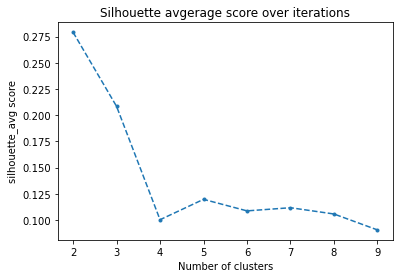

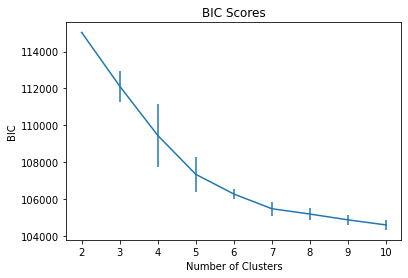

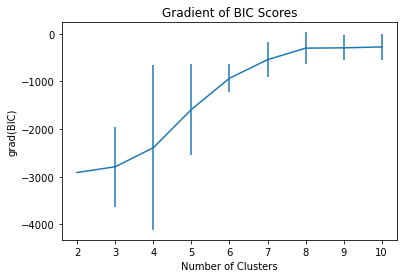

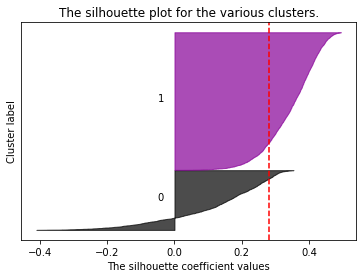

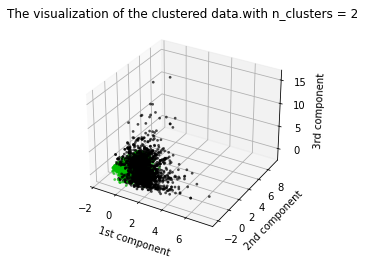

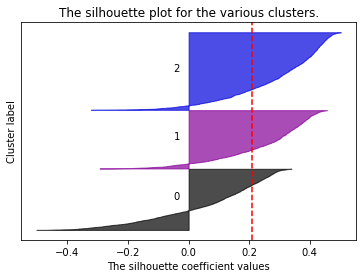

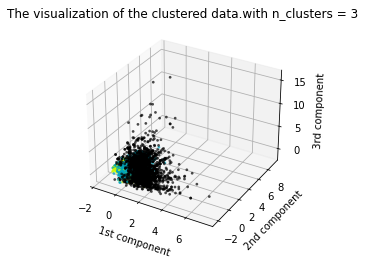

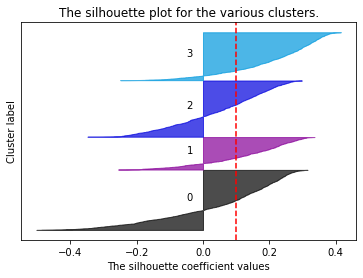

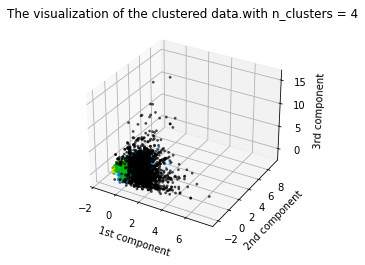

In [367]:
# Average silhouette score when using clustering from 2 to 10
max_cluster = 10;
model_type = 'EM'
silhouette_avg_plot(data_reduced_forest, max_cluster, model_type = model_type)

# Bayesin Information Criterion score when using clustering from 2 to 10
bic_plot(data_reduced_forest, max_cluster)

# plot the silhouette score over different clusters and visualize the data.
for cluser in range (2, 5):
    silhouette_and_data_plot(cluser, data_reduced_forest, model_type='EM', data_type='reduced',
                             xlim=[], ylim=[], zlim=[])

In [369]:
################ Adding clustering labels and distance to its centroid as new features 
################ into the dimensionality reduced data

# based on above sihoutte score and bic curve, choose cluster of 3 for EM clustering
EM_model = GaussianMixture(n_components=2,random_state=0)
EM_model.fit(data_reduced_forest)
cluster_labels = EM_model.predict(data_reduced_forest)   

centers = EM_model.means_

# calculate the Eclidean distance between each point to its corresponding center.
dist_list = []
for n in range(len(data_reduced_forest)):
    a_point         = data_reduced_forest[n]    # get a point in the dataset
    a_cluster_label = cluster_labels[0]      # get the label of this point in the clusters
    my_center       = centers[a_cluster_label]
    dist            = np.sqrt(sum(a_point-my_center)**2)  # the distance between a given data point to its corresponding center
    dist_list.append(dist)

dist_list = np.asarray(dist_list)  # get all the distances
# concatenate the clustering label and the distance after the reduced dimension data, serving as additional features
data_reduced_forest_features_EM = np.concatenate(
    (data_reduced_forest, cluster_labels[:, np.newaxis], dist_list[:, np.newaxis]),axis=1)

print(data_reduced_forest.shape)
print(data_reduced_forest_features_EM.shape)

(6497, 8)
(6497, 10)


### Running neural network algrithm for classification on the dimension reduced data using Random Forest

In [370]:
# with dimensionality reduced data using random projection
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'tanh',
                        alpha              = 0.001,  # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001,  # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_forest, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.8274004233211468
Testing accuracy is: 0.7692307692307693


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [371]:
# with dimensionality reduced data using random projection + kmeans feature
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'tanh',
                        alpha              = 0.001,  # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001,  # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_forest_features_Kmeans, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.787569751779873
Testing accuracy is: 0.7753846153846153


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [372]:
# with dimensionality reduced data using random projection + EM feature
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'tanh',
                        alpha              = 0.001,  # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001,  # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_forest_features_EM, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.8231672118529921
Testing accuracy is: 0.78


/opt/anaconda3/envs/cs7643-a1/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
